# Find best route on a map - Python Code

This is the article we worked with and used the code:
1. https://towardsdatascience.com/visualization-in-python-finding-routes-between-points-2d97d4881996

2. https://levelup.gitconnected.com/dijkstra-algorithm-in-python-8f0e75e3f16e

For a more detailed notes on how to use OSM, see this:
https://geoffboeing.com/2016/11/osmnx-python-street-networks/

It can be useful to watch these two videos, both explain clearly the Dijkstra Algorithm:

1. https://www.youtube.com/watch?v=bZkzH5x0SKU&ab_channel=FelixTechTips

2. https://www.youtube.com/watch?v=EFg3u_E6eHU&t=22s&ab_channel=SpanningTree

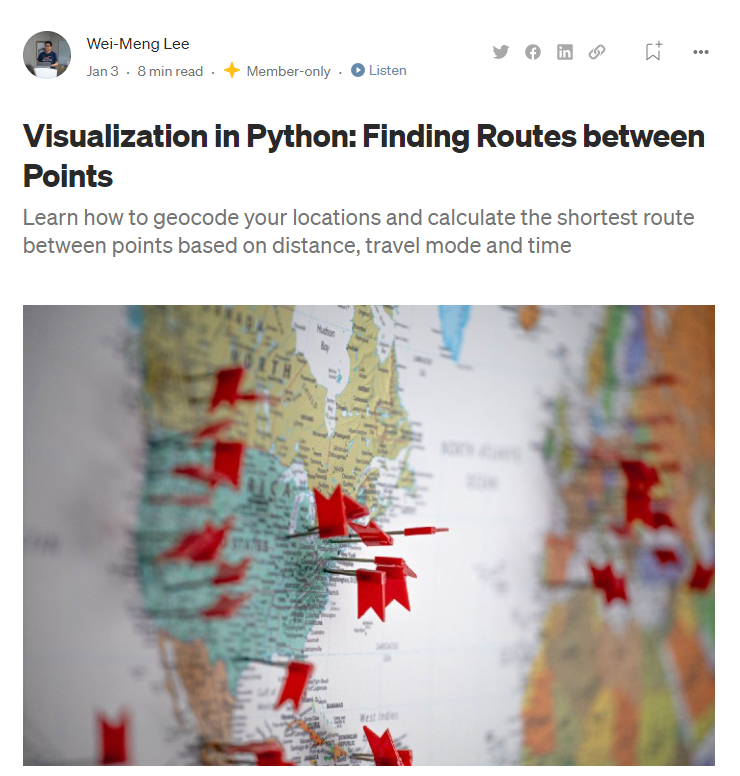

### Error handeling while installing OSM library etc.
Here are some errors we encountered while trying to run the code, and may help you on your computer.

1. [notice] A new release of pip available: 22.2.2 -> 22.3
To update, run: python.exe -m pip install --upgrade pip

2. pip wheel need an update, please run:
C:\Users\nobel\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip setuptools wheel

3. When trying to install osmnx
Returns an error: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.

## What we will do in this file?

1. __Find shortest route using OSM toolset and maps (and Dijkstra Graph Search).__ This is a very short code as OMS has a function that creates maps as well as function that finds route on the map. We will see how to run theswe functions

2. __Get to know the structure of our OSM map, route etc.__

3. __Find shortest route with "our" Dijkstra Graph Search code, and OSM map of nodes and verteces.__

4. __Find a path when some roads are blocked.__


Let's get started!




## 1. Find shortest route using OSM toolset and maps (and Dijkstra Graph Search)
First, we will demonstrate how to find shortest route using __existing__ functions in Open Street Map (OSM) libraries and Maps.

In [15]:
!pip install osmnx
!pip install scikit-learn
!pip install folium

In [17]:
import osmnx as ox
import networkx as nx
ox.settings.log_console=True
ox.settings.use_cache=True

# Generate a map (from OSM library) for the area we work in.
mode = 'drive'        # 'drive', 'bike', 'walk'
graph = ox.graph_from_place('Tel Aviv, Israel', network_type = mode)

# define the start and end points of the route in latlng coordinates
# Use this app, for example, to get the lat-lan coordinates of a place:
# https://www.latlong.net/

# Google TLV
start_lnglat = (34.794, 32.070)

# Tel Aviv University
end_lnglat = (34.802, 32.115)

# find the nearest node to the start location using OSM nearest node
orig_node = ox.nearest_nodes(graph, *start_lnglat)

# find the nearest node to the end location using OSM nearest node
dest_node = ox.nearest_nodes(graph, *end_lnglat)

#  find the shortest path using OSM library
shortest_route = nx.shortest_path(graph,
                                  orig_node,
                                  dest_node,
                                  weight='time')

ox.plot_route_folium(graph, shortest_route, tiles='openstreetmap')

## 2. Get to know the structure of our OSM map, route etc.
The following lines will help us get familiar with the many variables used when creating a map and finding a route on it using OSM functions. Specifically we will see:

1. How an edge is stored in the graph

2. How to look at all the edges connected to a specific node.

In [4]:
all_nodes = graph.nodes
all_edges = graph.edges
print('There are:', len(all_nodes), 'nodes in the graph representing the Map.')
print('There are:', len(all_edges), 'edges in the graph representing the Map.')
print('Origin node is:',orig_node)
print('There are:', len(shortest_route), 'edges in the route we found above.')
print('')
# stats = ox.basic_stats(graph)   # This function - stats - returns all kind of statistics about the graph
# print(stats)  

print('Example: ALL the data stored for each road segment (edge) in the map graph:')
print(graph.edges(shortest_route[1], data=True))  # show all the attributes of an edge (a dictionary)
print('')

# Finds node's edge neighbours, and print their attributes
for i in range(1,min(10,len(shortest_route))):   #shortest_route
    node = shortest_route[i]
    print('From node',node,'you can proceed to:')
    for from_node, to_node, att in graph.edges(node, data=True):  # data=True: returns ALL the attributes for each node
        print('- Road Seg.',att["osmid"], att.setdefault("name","no name"), 'going from node', from_node, 'to', to_node,)
        

There are: 6493 nodes in the graph representing the Map.
There are: 12501 edges in the graph representing the Map.
Origin node is: 442893209
There are: 31 edges in the route we found above.

Example: ALL the data stored for each road segment (edge) in the map graph:
[(442893216, 442893205, {'osmid': 963722491, 'oneway': True, 'name': 'יגאל אלון', 'highway': 'tertiary', 'reversed': False, 'length': 83.921, 'geometry': <shapely.geometry.linestring.LineString object at 0x0000024350C847F0>})]

From node 442893216 you can proceed to:
- Road Seg. 963722491 יגאל אלון going from node 442893216 to 442893205
From node 442893205 you can proceed to:
- Road Seg. 225708346 יגאל אלון going from node 442893205 to 2473987340
- Road Seg. 203762918 השלום going from node 442893205 to 1228098
From node 2473987340 you can proceed to:
- Road Seg. 239616075 השלום going from node 2473987340 to 2344604151
- Road Seg. 239616073 יגאל אלון going from node 2473987340 to 2137606211
From node 2344604151 you can proce

## 3. Find shortest route with "our" Dijkstra Graph Search code, and OSM map of nodes and verteces
We will now do our own __Dijkstra Graph Search__ using Open Street Map (OSM) Maps and Data. It follows these steps:

(This code is closely related to the explanation here: https://levelup.gitconnected.com/dijkstra-algorithm-in-python-8f0e75e3f16e)

1. We start with an empty Priority Queus (=Sorted queue, .get will always pop out the min value element in the queue)
2. We put the Starting point (start_node) in the queue with distance=0 (distance is the distance from the starting point)
3. As long as the queue is not emplty (at first, it has 1 element and so, not empty)

   3.1 Get the node with min distance value in the queue (we will now "work" on it and update it's distance from origin label)
   
   3.2 Mark that this node was visited (by the Dijkstra algorithm)
   
   3.3 If we are looking at the destination node - Our work is done. We arrived to the destination and can return the "route" (i.e. list of nodes) from the origin node to the destination node.
   
   3.4 Else (not the destination node): We look at all the nodes we can visit from the current node and for each node __not visited__ we add to our queue the distance (from the origin) to this node and keep track of all the nodes we need to go through from the origin to this node.
   
We stay in this loop (3) as long as our queue is not empty. We suppose to exit the loop when we reach the destination node, but if this never happens, and the queue gets empty, we exit with error: Roune NOT found.

In [5]:
# The following code implements Dijkstra search on a graph based on OSM Map.
# It is closely related to the explanation in this article:
# https://levelup.gitconnected.com/dijkstra-algorithm-in-python-8f0e75e3f16e

from queue import PriorityQueue  # We need to use the priority queue lib
                                 # PriorityQueue keeps the data in the queue sorted so that
                                 # PriorityQueue.get() from a priority queue will return the MIN value in the queue

# Dijkstra Algorithm for Shortest Path
def dijkstra0(graph, start_node, end_node):
    pq = PriorityQueue()
    pq.put((0, [start_node]))  # Start route by adding the start_node to the route_queue with value = 0
    
    visited = set()
    
    while not pq.empty():
        (dist, route) = pq.get()  # get pops the element with *min weight* in the queue
        visited.add(route[-1])  # looks at the last element (=node) in the route list and mark it was visited by our D algo.
        if route[-1] == end_node: # if we are looking at the destination node - We are done. We found a route
            print('Found Route!')
            return route
        for from_node, to_node, att in graph.edges(route[-1], data=True):  # Looks at all the nodes we can reach (i.e., looks at all the edges from current node and what new node they arrive to)
            if to_node not in visited:   # If we can reach a node *not* visited so far, then:
                pq.put((dist + att['length'], route + [to_node]))  # Add to our queue this new "option": To arrive to node "to_node" using a path of nodes we keep in "route" and we note the cost to go through this path is "dist" we keep track of for each route we check
                
    print('Route not found!')
    
my_route = dijkstra0(graph, orig_node, dest_node)

Found Route!


In [6]:
ox.plot_route_folium(graph, my_route, tiles='openstreetmap')

## 4. Find a path when some roads are blocked

We now slightly change our Dijkstra code so it can recognize blocked segments in the road map and avoid passing through them. To do this, we will now:

1. Add to the Dijkstra function the option to get names of road segments that are blocked.

2. We create a new set - blocked_streets - where we can block as many road segments as we like on the map by adding the name of the road segment as it appears in OSM map, to the set.

3. We then call Dijkstra algorithm with this set of blocked road segmants and get as an answer the shortest route that __does not__ pass through any of the blocked road segments.


In [7]:
from queue import PriorityQueue  # We need to use the priority queue lib
                                 # PriorityQueue keeps the data in the queue sorted so that
                                 # PriorityQueue.get() from a priority queue will return the MIN value in the queue

def weight_by_length(att):
    return att['length']

# Dijkstra Algorithm for Shortest Path
def dijkstra(graph, start_node, end_node, allowed_fn = lambda x: True):
    pq = PriorityQueue()
    pq.put((0, [start_node]))
    
    visited = set()
    
    while not pq.empty():
        (dist, route) = pq.get()  # get pops the element with min weight in the queue
        visited.add(route[-1])  # looks at the last element in the route list
        if route[-1] == end_node:
            print('found route!')
            return route
        for _, to_node, att in graph.edges(route[-1], data=True):
            if to_node not in visited and allowed_fn(att):
                pq.put((dist + att['length'], route + [to_node]))
                
    print('not found!')
    
my_route = dijkstra(graph, orig_node, dest_node)

found route!


In [8]:
ox.plot_route_folium(graph, my_route, tiles='openstreetmap')

In [12]:
# Example with some street names are blocked and cannot use them
blocked_streets = set()

def is_not_blocked(att):
    streetnames = att.get('name')
    if streetnames is None:
        streetnames = []   # if no street name, return empty list
    if isinstance(streetnames, str):
        streetnames = [streetnames] # if only one street name = return a list with this oner street name
    return blocked_streets.isdisjoint(streetnames) # if many street names, return a list with all these names and we ask, is any of these street names is blocked
   

In [13]:
blocked_streets.add('איילון צפון')
blocked_streets.add('נמיר')
#blocked_streets.add('השלום')
#blocked_streets.add('תובל')
#blocked_streets.add('יגאל אלון')


route_with_blocked_streets = dijkstra(graph, orig_node, dest_node, is_not_blocked)
ox.plot_route_folium(graph, route_with_blocked_streets, tiles='openstreetmap')

found route!


In [14]:
# I put the code that shows all nodes in the shortest route here again
# so you can see the names of the road segmants along the selected route and block some of them in the code above
#and see how the algorithm finds a new route without them. Try it.

# Finds node's edge neighbours, and print their attributes
for i in range(1,min(99,len(route_with_blocked_streets))):   #shortest_route
    node = route_with_blocked_streets[i]
    print('From node',node,'you can proceed to:')
    for from_node, to_node, att in graph.edges(node, data=True):  # data=True: returns ALL the attributes for each node
        print('- Road Seg.',att["osmid"], att.setdefault("name","no name"), 'going from node', from_node, 'to', to_node,)

From node 442893216 you can proceed to:
- Road Seg. 963722491 יגאל אלון going from node 442893216 to 442893205
From node 442893205 you can proceed to:
- Road Seg. 225708346 יגאל אלון going from node 442893205 to 2473987340
- Road Seg. 203762918 השלום going from node 442893205 to 1228098
From node 2473987340 you can proceed to:
- Road Seg. 239616075 השלום going from node 2473987340 to 2344604151
- Road Seg. 239616073 יגאל אלון going from node 2473987340 to 2137606211
From node 2344604151 you can proceed to:
- Road Seg. 225708345 יגאל אלון going from node 2344604151 to 1329704
- Road Seg. 184657041 גבעת התחמושת going from node 2344604151 to 2344604158
From node 2344604158 you can proceed to:
- Road Seg. 184657041 גבעת התחמושת going from node 2344604158 to 8319637684
From node 8319637684 you can proceed to:
- Road Seg. 966536980 גבעת התחמושת going from node 8319637684 to 286643575
- Road Seg. 239616099 no name going from node 8319637684 to 2989922193
From node 286643575 you can proceed to